In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
feature_type = '5e-4_qval'
in_dir = '../../MBC_validation/validation_analysis/validation_results'
iterations = 1000


In [3]:
#import data
probabilities = pd.read_csv(in_dir+'/'+feature_type+'.probabilities.txt', sep='\t')
AUC_CI = pd.read_csv(in_dir+'/'+feature_type+'.AUC_CI.txt', sep='\t')
accuracy_CI = pd.read_csv(in_dir+'/'+feature_type+'.accuracy_CI.txt', sep='\t')
print(len(probabilities))
probabilities = probabilities.set_index('sample')



probabilities.head()

144


,coverage,ER_status,tumor_fraction,patient_ID,status,dataset,HR status,timepoint_within_pt_ctDNAonly,site_group,central_coverage_ER_neg_heme.5e-4_qval,...,amplitude_ER_pos_heme.5e-4_qval,amplitude_ER_pos_specific.5e-4_qval,mean_coverage_ER_neg_heme.5e-4_qval,mean_coverage_ER_neg_specific.5e-4_qval,mean_coverage_ER_pos_heme.5e-4_qval,mean_coverage_ER_pos_specific.5e-4_qval,prediction,probability,accuracy,tfx_group
sample,,,,,,,,,,,,,,,,,,,,,
B-515465_1,0.195788,NaN,0.05231,B-515465,0,MBC_Stover,TNBC,1.0,5e-4_qval,-0.349179,...,-0.571409,-1.137017,0.574094,0.509878,0.344819,0.801041,0,0.425102,1,0.05-0.1_TFx
B-515465_2,0.247780,NaN,0.04519,B-515465,0,MBC_Stover,TNBC,2.0,5e-4_qval,0.695610,...,0.961870,-1.082093,-0.044058,-0.045420,0.090961,0.857317,0,0.333115,1,<0.05_TFx
B-515465_3,0.116621,NaN,0.78650,B-515465,0,MBC_Stover,TNBC,3.0,5e-4_qval,-2.316727,...,-1.085730,0.412602,-2.479924,-1.990319,0.695689,0.414976,0,0.017063,1,>0.1_TFx
B-515465_4,0.128281,NaN,0.03258,B-515465,0,MBC_Stover,TNBC,4.0,5e-4_qval,-1.253244,...,0.308389,0.857068,1.205822,0.767212,-0.110035,0.117257,1,0.755862,0,<0.05_TFx
B-515465_5,0.286903,NaN,0.03276,B-515465,0,MBC_Stover,TNBC,5.0,5e-4_qval,0.253963,...,-0.129730,-1.115134,0.508605,0.666987,0.621913,-0.094534,1,0.541909,0,<0.05_TFx


In [4]:
export_columns = ['patient_ID','dataset','tumor_fraction', 'coverage','timepoint_within_pt_ctDNAonly', 
       'HR status','ER_status','status','probability', 'prediction']

for_supplement = probabilities[export_columns]
for_supplement = for_supplement.rename(columns = {'timepoint_within_pt_ctDNAonly':'sample_order','probability':'probability_ER+'})

for_supplement['dataset'] = for_supplement['dataset'].replace('MBC_Stover','Independent_MBC_cohort')
for_supplement['dataset'] = for_supplement['dataset'].replace('BRCA_Ghana_ULP','Ahuno_et_al_cohort')
for_supplement['dataset'] = for_supplement['dataset'].replace('MBC_Dawson_downsampled','Bujak_et_al_cohort')
for_supplement['dataset'].value_counts()

for_supplement.to_csv('files/S14_MBC_validation_subtyping.tsv', sep='\t')
print(len(for_supplement))

144


In [5]:
#print number of unique patients
print('total samples:',len(probabilities))
probabilities
print('unique patients', len(probabilities['patient_ID'].unique()))
print('first TFx >0.1',len(probabilities[probabilities['tumor_fraction']>=0.1]['patient_ID'].unique()))

#get only first timepoints for futher analysis
probabilities = probabilities[~(probabilities['timepoint_within_pt_ctDNAonly']>1)]
print('for ROC curves',len(probabilities))

total samples: 144
unique patients 71
first TFx >0.1 30
for ROC curves 71


In [6]:
print('all patients')
print(probabilities['status'].value_counts())

print('high tfx')
print(probabilities[probabilities['tumor_fraction']>=0.1]['status'].value_counts())

print('low tfx')
print(probabilities[probabilities['tumor_fraction']<0.1]['status'].value_counts())

all patients
1    49
0    22
Name: status, dtype: int64
high tfx
1    17
0     7
Name: status, dtype: int64
low tfx
1    32
0    15
Name: status, dtype: int64


In [7]:
color_dict ={'<0.05_TFx':'tab:purple','0.05-0.1_TFx':'tab:olive','>0.1_TFx':'tab:cyan', '>0.05_TFx':'tab:grey','All samples':'tab:grey'}

In [8]:
accuracy_CI

,group,median,0.025,0.975
0,All samples,0.73239,0.61972,0.83099
1,>0.05_TFx,0.91892,0.82353,1.00000
2,0.05-0.1_TFx,0.84615,0.60000,1.00000
3,<0.05_TFx,0.54286,0.37829,0.70270
4,>0.1_TFx,0.96000,0.86364,1.00000


0.84615 0.6 1.0
0.9 0.59574 1.0
0.96 0.86364 1.0
0.98413 0.89087 1.0
0.91892 0.82353 1.0
0.96244 0.87717 1.0


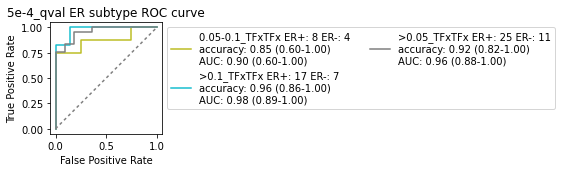

In [9]:
#plot the ROC curves without <0.05
fig,ax = plt.subplots(figsize=(9,2.5))


for group in ['0.05-0.1_TFx', '>0.1_TFx', '>0.05_TFx']:
    if group=='>0.05_TFx':
        current = probabilities[probabilities['tumor_fraction']>0.05]
    else:
        current = probabilities[(probabilities['tfx_group']==group)]
        
    num_ER_pos = len(current[current['status']==1])
    num_ER_neg = len(current[current['status']==0])

    accuracy = accuracy_CI[(accuracy_CI['group']==group) ]['median']
    if not len(accuracy)==1:
        print('error')
    accuracy = accuracy.values[0]
    
    #get the CI from the bootstrap data
    lower_acc = accuracy_CI[(accuracy_CI['group']==group) ]['0.025'].values[0]
    upper_acc = accuracy_CI[(accuracy_CI['group']==group) ]['0.975'].values[0]
    
    print(accuracy,lower_acc,upper_acc)
    
    AUC = AUC_CI[(AUC_CI['group']==group)]['median']    
    if not len(AUC)==1:
        print('error')
    AUC = AUC.values[0]
    
    lower_AUC = AUC_CI[(AUC_CI['group']==group) ]['0.025'].values[0]
    upper_AUC = AUC_CI[(AUC_CI['group']==group) ]['0.975'].values[0]
    print(AUC,lower_AUC,upper_AUC)
    
    fpr, tpr, _ = roc_curve(current['status'].values,current['probability'])
    label = group+'TFx ER+: '+str(num_ER_pos)+' ER-: '+str(num_ER_neg)+\
        '\naccuracy: '+ format(accuracy,'.2f')+' ('+format(lower_acc, '.2f')+'-'+format(upper_acc, '.2f')+')'+\
        '\nAUC: '+ format(AUC,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'
    ax.plot(fpr,tpr, label = label, color=color_dict[group])

ax.legend(bbox_to_anchor = [1,1], loc = 'upper left', ncol = 2)
ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(feature_type+' ER subtype ROC curve')

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('plots/'+feature_type+'_validation_ROC.pdf')

0.54286 0.37829 0.7027
0.38849 0.1875 0.60758
0.84615 0.6 1.0
0.9 0.59574 1.0
0.96 0.86364 1.0
0.98413 0.89087 1.0


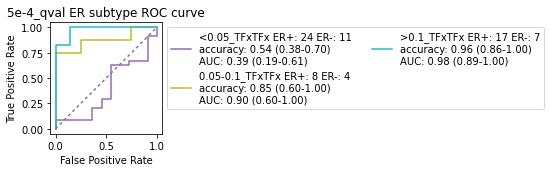

In [10]:
#for supplement
#plot the ROC curves with <0.05
fig,ax = plt.subplots(figsize=(9,2.5))

for group in ['<0.05_TFx','0.05-0.1_TFx', '>0.1_TFx']:
#     if group=='All samples':
#         current = probabilities
#     else:
    current = probabilities[(probabilities['tfx_group']==group)]
    num_ER_pos = len(current[current['status']==1])
    num_ER_neg = len(current[current['status']==0])

    accuracy = accuracy_CI[(accuracy_CI['group']==group) ]['median']
    if not len(accuracy)==1:
        print('error')
    accuracy = accuracy.values[0]
    
    #get the CI from the bootstrap data
    lower_acc = accuracy_CI[(accuracy_CI['group']==group) ]['0.025'].values[0]
    upper_acc = accuracy_CI[(accuracy_CI['group']==group) ]['0.975'].values[0]
    
    print(accuracy,lower_acc,upper_acc)
    
    AUC = AUC_CI[(AUC_CI['group']==group)]['median']    
    if not len(AUC)==1:
        print('error')
    AUC = AUC.values[0]
    
    lower_AUC = AUC_CI[(AUC_CI['group']==group) ]['0.025'].values[0]
    upper_AUC = AUC_CI[(AUC_CI['group']==group) ]['0.975'].values[0]
    print(AUC,lower_AUC,upper_AUC)
    
    fpr, tpr, _ = roc_curve(current['status'].values,current['probability'])
    label = group+'TFx ER+: '+str(num_ER_pos)+' ER-: '+str(num_ER_neg)+\
        '\naccuracy: '+ format(accuracy,'.2f')+' ('+format(lower_acc, '.2f')+'-'+format(upper_acc, '.2f')+')'+\
        '\nAUC: '+ format(AUC,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'
    ax.plot(fpr,tpr, label = label, color=color_dict[group])

ax.legend(bbox_to_anchor = [1,1], loc = 'upper left', ncol = 2)
ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(feature_type+' ER subtype ROC curve')

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('plots/'+feature_type+'_validation_ROC_supplement.pdf')